In [1]:
!pip3 install pmlb

Processing dataset: GAMETES_Epistasis_2_Way_1000atts_0.4H_EDM_1_EDM_1_1
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Best Pipeline: ('MinMaxScaler', 'LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'), Best Accuracy: 0.5125, RF Accuracy: 0.49375, GB Accuracy: 0.4875
Processing dataset: GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Best Pipeline: ('StandardScaler', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier'), Best Accuracy: 0.628125, RF Accuracy: 0.575, GB Accuracy: 0.578125
Processing dataset: GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1
Generation 1
Generation 2
Generation 3
Generatio

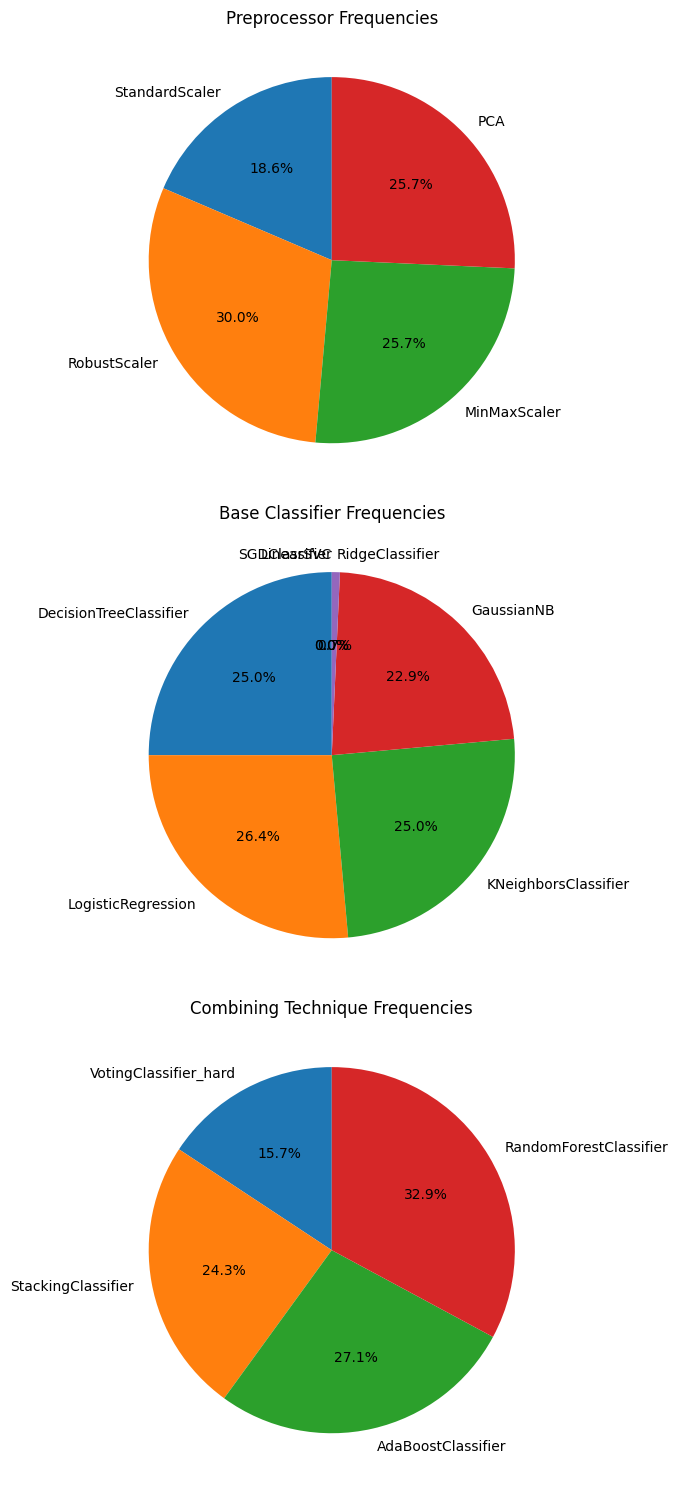

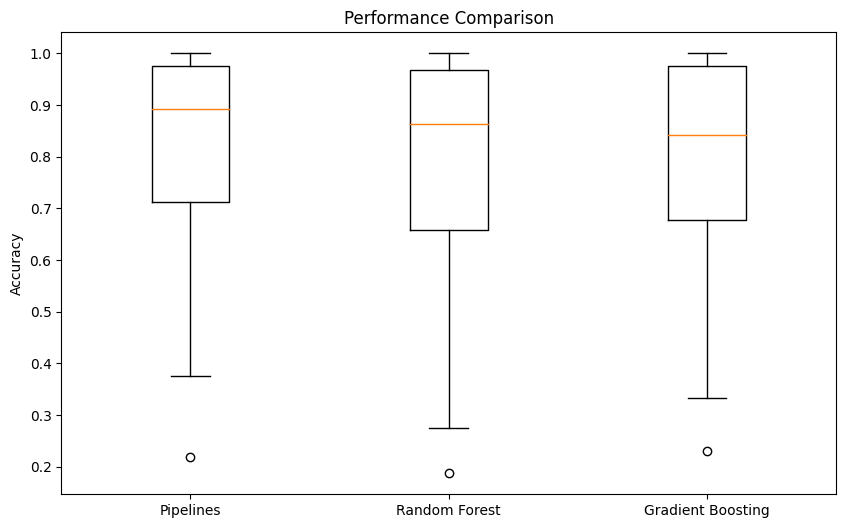

In [2]:
import warnings
import numpy as np
import pandas as pd
import pmlb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
import random
import matplotlib.pyplot as plt

# Define grammar
grammar = {
    'preprocessing': ['StandardScaler', 'RobustScaler', 'MinMaxScaler', 'PCA'],
    'classifiers': ['DecisionTreeClassifier', 'LogisticRegression', 'KNeighborsClassifier', 'GaussianNB', 'RidgeClassifier', 'SGDClassifier', 'LinearSVC'],
    'combinations': ['VotingClassifier_hard', 'StackingClassifier', 'AdaBoostClassifier', 'RandomForestClassifier']
}

# Genotype to phenotype mapping
def genotype_to_phenotype(genotype):
    if len(genotype) != 4:
        return None
    
    total_preprocessing = len(grammar['preprocessing'])
    total_classifiers = len(grammar['classifiers'])
    total_combinations = len(grammar['combinations'])

    preprocessing_idx = genotype[0] % total_preprocessing
    classifier1_idx = genotype[1] % total_classifiers
    classifier2_idx = genotype[2] % total_classifiers
    combination_idx = genotype[3] % total_combinations

    preprocessing = grammar['preprocessing'][preprocessing_idx]
    classifier1 = grammar['classifiers'][classifier1_idx]
    classifier2 = grammar['classifiers'][classifier2_idx]
    combination = grammar['combinations'][combination_idx]
    
    return preprocessing, classifier1, classifier2, combination

# Fitness function
# Evaluate fitness function
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    preprocessing_name, clf1_name, clf2_name, combination_name = pipeline
    preprocessing = globals()[preprocessing_name]()
    clf1 = globals()[clf1_name]()
    clf2 = globals()[clf2_name]()
    
    # Set default max_iter for classifiers that support it
    if clf1_name in ['LogisticRegression', 'SGDClassifier']:
        clf1.set_params(max_iter=50000)
    if clf2_name in ['LogisticRegression', 'SGDClassifier']:
        clf2.set_params(max_iter=50000)
    
    # Hardcoding the 'dual' parameter to suppress the FutureWarning for LinearSVC
    if clf1_name == 'LinearSVC':
        clf1 = globals()[clf1_name](dual=False,max_iter=30000)
    if clf2_name == 'LinearSVC':
        clf2 = globals()[clf2_name](dual=False,max_iter=30000)
    
    if combination_name == 'VotingClassifier_hard':
        ensemble = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)], voting='hard')
    elif combination_name == 'StackingClassifier':
        ensemble = StackingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)], final_estimator=LogisticRegression(max_iter=30000))
    elif combination_name == 'AdaBoostClassifier':
        ensemble = AdaBoostClassifier(estimator=DecisionTreeClassifier())
    elif combination_name == 'RandomForestClassifier':
        ensemble = RandomForestClassifier()
        
    model = make_pipeline(preprocessing, ensemble)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Genetic Algorithm parameters
population_size = 40
num_generations = 15
mutation_rate = 0.3

warnings.filterwarnings("ignore")
# Load dataset
results = []
pipeline_accuracies = []
rf_accuracies = []
gb_accuracies = []
rf_better_count = 0
gb_better_count = 0

for dataset_name in pmlb.classification_dataset_names[:70]:
    print(f"Processing dataset: {dataset_name}")
    X, y = pmlb.fetch_data(dataset_name, return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    population = [
    [random.randint(0, len(grammar['preprocessing']) + len(grammar['classifiers']) + len(grammar['combinations']) - 1) for _ in range(4)]
    for _ in range(population_size)]

    # Evolutionary loop
    for generation in range(num_generations):
        print(f"Generation {generation + 1}")
        # Convert genotypes to phenotypes
        phenotypes = [genotype_to_phenotype(genotype) for genotype in population]
        # Evaluate fitness
        fitness_scores = [evaluate_pipeline(phenotype, X_train, y_train, X_test, y_test) for phenotype in phenotypes]

        # Select parents based on fitness scores (roulette wheel selection)
        total_fitness = sum(fitness_scores)
        probabilities = [score / total_fitness for score in fitness_scores]
        parent_indices = np.random.choice(range(population_size), size=population_size, p=probabilities)
        parents = [population[i] for i in parent_indices]

        # Apply mutation
        for i in range(population_size):
            if random.random() < mutation_rate:
                # Randomly select one gene to mutate
                gene_to_mutate = random.randint(0, 3)
                parents[i][gene_to_mutate] = random.randint(0, len(grammar['preprocessing']) - 1)

        # Replace old population with new population
        population = parents

        # Introduce new random individuals to maintain diversity
        while len(population) < population_size:
            new_genotype = [random.randint(0, len(grammar['preprocessing']) - 1) for _ in range(4)]
            population.append(new_genotype)

    # Find best pipeline
    best_pipeline = genotype_to_phenotype(population[np.argmax(fitness_scores)])
    best_accuracy = max(fitness_scores)
    
    # Calculate accuracies for default Random Forest and Gradient Boost classifiers
    rf = RandomForestClassifier(random_state=42,n_jobs=-1)
    gb = GradientBoostingClassifier(random_state=42)
    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
    gb_accuracy = accuracy_score(y_test, gb.predict(X_test))
    
    results.append([dataset_name, best_pipeline, best_accuracy, rf_accuracy, gb_accuracy])
    pipeline_accuracies.append(best_accuracy)
    rf_accuracies.append(rf_accuracy)
    gb_accuracies.append(gb_accuracy)

    print(f"Best Pipeline: {best_pipeline}, Best Accuracy: {best_accuracy}, RF Accuracy: {rf_accuracy}, GB Accuracy: {gb_accuracy}")
    
    # Count how many times RF and GB perform better than the generated pipeline
    if rf_accuracy > best_accuracy:
        rf_better_count += 1
    if gb_accuracy > best_accuracy:
        gb_better_count += 1

# Calculate mean accuracies
mean_pipeline_accuracy = np.mean(pipeline_accuracies)
mean_rf_accuracy = np.mean(rf_accuracies)
mean_gb_accuracy = np.mean(gb_accuracies)

print(f"Mean Pipeline Accuracy: {mean_pipeline_accuracy}")
print(f"Mean RF Accuracy: {mean_rf_accuracy}")
print(f"Mean GB Accuracy: {mean_gb_accuracy}")
print(f"Number of times RF performed better than the generated pipeline: {rf_better_count}")
print(f"Number of times GB performed better than the generated pipeline: {gb_better_count}")

# Store results in a CSV file
df = pd.DataFrame(results, columns=['Dataset', 'Best Pipeline', 'Pipeline Accuracy', 'RF Accuracy', 'GB Accuracy'])
df.to_csv('pipeline_results_no_parallel.csv', index=False)

# Visualization of most favored preprocessor, base classifier, and combining technique as pie charts
preprocessor_counts = {preprocessor: 0 for preprocessor in grammar['preprocessing']}
classifier_counts = {classifier: 0 for classifier in grammar['classifiers']}
combining_counts = {combining: 0 for combining in grammar['combinations']}

for _, best_pipeline, _, _, _ in results:
    preprocessing, classifier1, classifier2, combination = best_pipeline
    preprocessor_counts[preprocessing] += 1
    classifier_counts[classifier1] += 1
    classifier_counts[classifier2] += 1
    combining_counts[combination] += 1

fig, axs = plt.subplots(3, 1, figsize=(15, 15))

axs[0].pie(preprocessor_counts.values(), labels=preprocessor_counts.keys(), autopct='%1.1f%%', startangle=90)
axs[0].set_title('Preprocessor Frequencies')

axs[1].pie(classifier_counts.values(), labels=classifier_counts.keys(), autopct='%1.1f%%', startangle=90)
axs[1].set_title('Base Classifier Frequencies')

axs[2].pie(combining_counts.values(), labels=combining_counts.keys(), autopct='%1.1f%%', startangle=90)
axs[2].set_title('Combining Technique Frequencies')

plt.tight_layout()
plt.savefig('frequencies_pie_charts.png')
plt.show()

# Visualization comparison of performance
pipeline_accuracies = [row[2] for row in results]
rf_accuracies = [row[3] for row in results]
gb_accuracies = [row[4] for row in results]

plt.figure(figsize=(10, 6))
plt.boxplot([pipeline_accuracies, rf_accuracies, gb_accuracies], labels=['Pipelines', 'Random Forest', 'Gradient Boosting'])
plt.title('Performance Comparison')
plt.ylabel('Accuracy')
plt.savefig('performance_comparison.png')
plt.show()
